<a href="https://colab.research.google.com/github/jitbnerejee4/jit/blob/fastai/Copy_of_lesson3_camvid_tiramisu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation with CamVid

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [3]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git


Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 11.44 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [4]:
path2 = Path('/content/SegNet-Tutorial/CamVid'); path2

PosixPath('/content/SegNet-Tutorial/CamVid')

In [5]:
path2.ls()

[PosixPath('/content/SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val'),
 PosixPath('/content/SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/testannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/train'),
 PosixPath('/content/SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/test')]

## Data

In [7]:
fnames = get_image_files(path2/'val')
fnames[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08151.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08005.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08059.png')]

In [8]:
lbl_names = get_image_files(path2/'valannot')
lbl_names[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08151.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08005.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08059.png')]

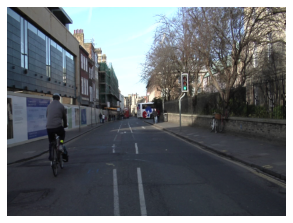

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

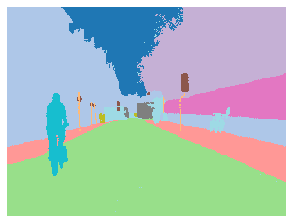

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

## Datasets

In [0]:
bs = 8

In [0]:
src = (SegmentationItemList.from_folder(path2)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

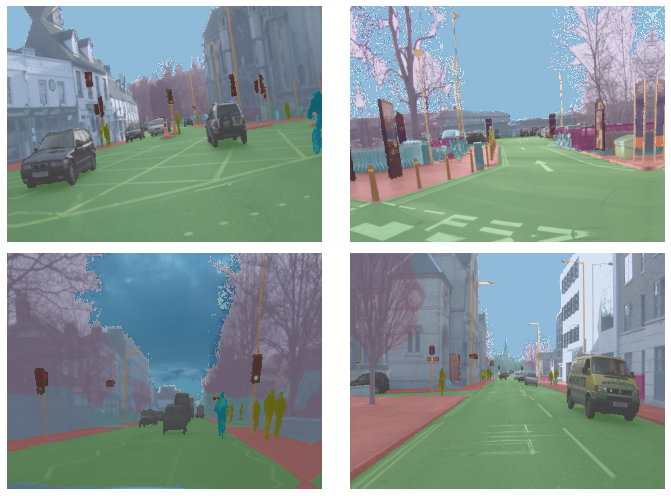

In [17]:
data.show_batch(2, figsize=(10,7))

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
wd=1e-2

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


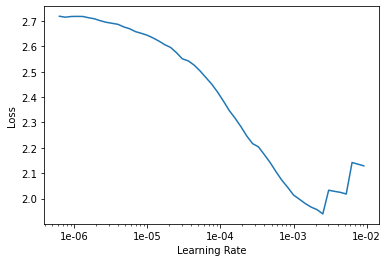

In [21]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=2e-3

In [23]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.146402,0.819227,0.778407,00:52
1,0.789464,0.576742,0.844649,00:46
2,0.623884,0.587418,0.847156,00:46
3,0.529144,0.647489,0.795054,00:46
4,0.567565,0.685329,0.801427,00:46
5,0.511638,0.440082,0.873920,00:46
6,0.459943,0.387799,0.892131,00:45
7,0.447162,0.351336,0.890497,00:45
8,0.408503,0.335596,0.895586,00:45
9,0.352564,0.295503,0.897422,00:45


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/100,lr)

In [28]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.291537,0.281321,0.916645,00:49
1,0.286190,0.273101,0.909143,00:47
2,0.277595,0.290381,0.907151,00:48
3,0.272886,0.291200,0.910420,00:48
4,0.285792,0.337665,0.912969,00:48
5,0.309421,0.317207,0.910298,00:48
6,0.310219,0.306312,0.918311,00:48
7,0.295054,0.300494,0.917565,00:47
8,0.295198,0.290432,0.909648,00:47
9,0.275611,0.313755,0.907978,00:47


In [0]:
learn.save('stage-2');

## Go big

In [30]:
learn=None
gc.collect()

46

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
size = src_size
bs=8

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


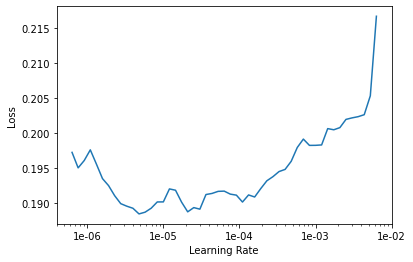

In [34]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [36]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.194025,0.236157,0.930765,00:46
1,0.193310,0.241871,0.929068,00:44
2,0.194967,0.263297,0.922374,00:45
3,0.190990,0.245036,0.927616,00:45
4,0.189476,0.219890,0.937638,00:45
5,0.190668,0.247953,0.930989,00:45
6,0.187834,0.230688,0.935734,00:45
7,0.190313,0.269961,0.927063,00:45
8,0.183185,0.242470,0.929148,00:45
9,0.170448,0.241605,0.931542,00:45


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/1000,lr/10)

In [41]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.157877,0.230360,0.935515,00:49
1,0.156758,0.225959,0.937891,00:47
2,0.156756,0.238929,0.935512,00:47
3,0.155219,0.234711,0.937191,00:47
4,0.151835,0.240730,0.935572,00:47
5,0.150122,0.244720,0.935878,00:47
6,0.150237,0.242695,0.935421,00:47
7,0.148961,0.238309,0.937389,00:47
8,0.147863,0.234397,0.937886,00:47
9,0.146717,0.239845,0.937005,00:47


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

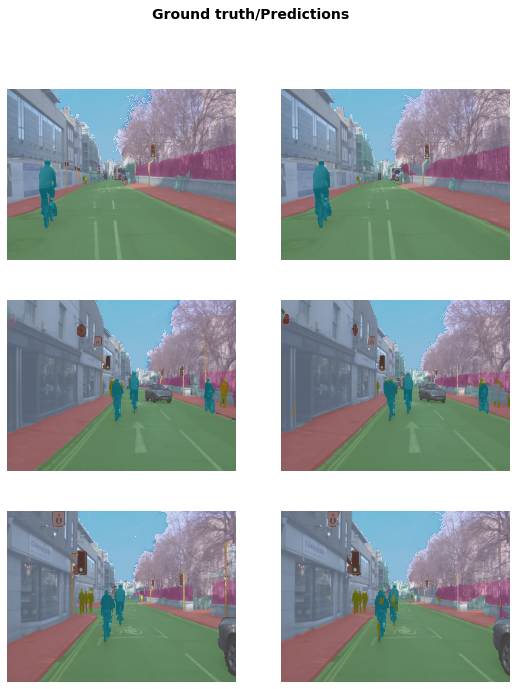

In [44]:
learn.show_results(rows=3, figsize=(9,11))

## fin

In [0]:
# start: 480x360

In [0]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 64, 180, 240]    9408       False     
______________________________________________________________________
BatchNorm2d          [8, 64, 180, 240]    128        True      
______________________________________________________________________
ReLU                 [8, 64, 180, 240]    0          False     
______________________________________________________________________
MaxPool2d            [8, 64, 90, 120]     0          False     
______________________________________________________________________
Conv2d               [8, 64, 90, 120]     36864      False     
______________________________________________________________________
BatchNorm2d          [8, 64, 90, 120]     128        True      
______________________________________________________________________
ReLU                 [8, 64, 90, 120]     0          False     
______________________________________________________________